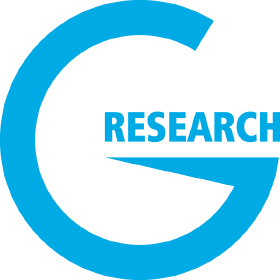  <p style="text-align:center;"><span style="font-size:80px;"><span style="color:orange;"> <i>Crypto Forecasting</i> </span></span></p>
  
<span style="font-size:18px;"><span style="font-family:cursive;">
  <b>Author: Vincent Weimer <br>
      Date: 2022-01-13</b>
    </span>
  
<hr></hr> 

In [ ]:
%%capture

## Import Libraries
import numpy as np # linear algebra
from numpy.random import seed 
import math 

from scipy.stats import normaltest

import pandas as pd # data processing 
pd.options.display.max_rows = 100
pd.options.display.max_seq_items = 2000
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import datetime as dt

!pip -q install mplfinance
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mpl_dates
plt.rcParams.update({'font.size': 14})
import seaborn as sns
plt.style.use('seaborn')
sns.set_style('whitegrid')

!pip install talib-binary # install talib for feature engineering 
import talib
from talib import RSI, BBANDS, MACD, ATR

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

import statsmodels as sm

import joblib

# Fix seed for reproducible results
SEED = 42
np.random.seed(SEED)

In [ ]:
## Import data
data_folder = "../input/g-research-crypto-forecasting/"
!ls $data_folder

### Example Sample Submission

In [ ]:
example_sample_submission = pd.read_csv(data_folder + "example_sample_submission.csv")
print(example_sample_submission.shape)
example_sample_submission.head()

### Example Test

In [ ]:
%%time

test_df = pd.read_csv(data_folder + "example_test.csv")
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], unit='s') 
print(test_df.shape)
test_df.head()

<b><i>Important!! Test data starts at 2021-06-13 and training data ends at 2021-09-21. To prevent data leakage, we need to filter train_df before the test data starts.</i></b>

## Preprocessing train data

The data contains more than 24 million rows! We need to reduce its memory using the following function.

In [ ]:
%%time 

def reduce_mem_usage(df): ## Copied directly from other Kagglers! ##
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
%%time 
assets_df = pd.read_csv(data_folder + "asset_details.csv")
assets_df = assets_df.sort_values(by='Asset_ID')

tickers = ['BNB', 'BTC', 'BCH', 'ADA', 'DOGE', 'EOS', 'ETH', 'ETC', 'IOTA', 'LTC', 'MKR', 'XMR', 'XLM', 'TRX']

# mappings
mapping_name = dict(assets_df[['Asset_ID', 'Asset_Name']].values)
mapping_weight = dict(assets_df[['Asset_ID', 'Weight']].values)
mapping_tickers = dict(enumerate(tickers))

# data types
dtypes = {
    'timestamp': str,
    'Asset_ID': np.int8,
    'Count': np.int32,
    'Open': np.float64,
    'High': np.float64,
    'Low': np.float64,
    'Close': np.float64,
    'Volume': np.float64,
    'VWAP': np.float64,
    'Target': np.float64,
}

# formatting
text_formats = {
   'PURPLE': '\033[95m',
   'CYAN': '\033[96m',
   'DARKCYAN': '\033[36m',
   'BLUE': '\033[94m',
   'GREEN': '\033[92m',
   'YELLOW': '\033[93m',
   'RED': '\033[91m',
   'BOLD': '\033[1m',
   'UNDERLINE': '\033[4m',
   'END': '\033[0m'
}

RED = text_formats['RED']
BOLD = text_formats['BOLD']
END = text_formats['END']

df_train_raw = pd.read_csv(data_folder + "train.csv", dtype=dtypes)
# df_train_raw = reduce_mem_usage(df_train_raw) # Memory reduced by 34.8%
df_train_raw.head()

## Prepare first train data
Taking in the raw train data, we wrangle the data in a first step perform the following steps:
* Transform unix timestamp to a regular timestamp
* Extract simple date values like date, year, and month
* Add colomns from asset details including the ticket, which makes the Data Frames more easy to filter
* Rename count to interval_trade_count


In [ ]:
%%time

def prepare_train_data(df):
    """This function takes in the raw training data and wrangles the data in the shape and types 
    required for further research"""
    
    CUTOFF_DATE = '2021-06-13 00:00:00'
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')       # convert from unix to datetime timestamp
    df = df.set_index('timestamp')                                    # set date as index column
    
    dates = df.index.get_level_values('timestamp')
    df['date'] = pd.to_datetime(dates.date)
    df['date'] = df['date'].dt.strftime('%Y%m%d').astype(int)         # SLOWS IT DOWN BY 3 MINS! NEED STH BETTER
    df['year'] = dates.year
    df['month'] = dates.month
    
    df["asset_name"] = df["Asset_ID"].map(mapping_name)
    df["asset_weight"] = df["Asset_ID"].map(mapping_weight)
    df["ticker"] = df["Asset_ID"].map(mapping_tickers)
    
    df = df.rename({'Count': 'interval_trade_count'}, axis=1)
    df.columns = map(str.lower, df.columns)
    
    df.sort_index()
    df = df[(df.index < CUTOFF_DATE)]
    
    total_num_records = df.shape[0]
    print(f"Total number of records in train dataset: {total_num_records}")
    
    return df

df_train = prepare_train_data(df_train_raw)
print(df_train.dtypes)
df_train.head()

In [ ]:
df_vwap_inf = np.where(np.isinf(df_train['vwap']))
print(df_vwap_inf)
print(len(df_vwap_inf))



In [ ]:
def find_missing_rows(df, start, end, asset):
    """This function calculates how many missing rows each crypto asset has."""
    
    num_rows = len(df.index)
    num_missing_rows = len(pd.date_range(start=start, end=end, freq='min').difference(df.index))
    print(f"{asset} total number of records: " + BOLD + f"{num_rows}" + END +  \
          ", Total number of missing minute records: " + BOLD + f"{num_missing_rows}" + END)
    
def populate_missing_rows(df):
    """This function populates missing minute data rows with Null values."""
    
    asset, start_date, end_date = df.iloc[0]['asset_name'], df.index[0], df.index[-1]
    print(f"{asset} start date: {start_date}, end date: {end_date}")
    find_missing_rows(df, start_date, end_date, asset)
    
    df = df.asfreq(freq='T', method='ffill')  # forward fill missing time series data
    print(f"Populating missing {asset} data...")
    find_missing_rows(df, start_date, end_date, asset)
    print('\n')
    
    return df
    
crypto_dfs = list()
    
for i in list(range(14)):
    symbol_df = df_train[df_train['asset_id'] == i]
    crypto_dfs.append(populate_missing_rows(symbol_df))


df_train = pd.concat(crypto_dfs).sort_index()  
# print(df_train.dtypes)
# print(len(df_train.index))
# df_train.head()

In [ ]:
%%time
# Generate dictionary of Dataframes for all tickers and store in dict..
def generate_crypto_dfs():
    """Returns a dictionary of dataframes with key(Ticker):value(Dataframe that belongs to that ticker)"""
    
    return {ticker:df_train.query("ticker == @ticker") for ticker in tickers}

all_cryptos = generate_crypto_dfs()

In [ ]:
## Filter on a few data frames to work with (BTC, ETH, DOGE)
btc = all_cryptos['BTC']
eth = all_cryptos['ETH']
doge = all_cryptos['DOGE']
bnb = all_cryptos['BNB']

print(f"DOGE unique years: {doge.year.unique()}")
print(f"BTC unique years: {btc.year.unique()}")
print(f"Number of BTC records: {len(btc.index)}")

# doge_filtered = doge.query('year >= 2020')
# btc_filtered = btc.query('year >= 2020')

In [ ]:
# print(len(btc_filtered.index))
# print(len(doge_filtered.index))


# doge.index[-1]

In [ ]:
# Function that gives opportunity to resample a time series data frame

def resample_timeseries(df, offset='H'):
    """Resampes a timeseries dataframe given the offset forwarded in the function"""
    
    df = df.reset_index().groupby(['asset_id', 'ticker']).resample(offset, on='timestamp', origin='start').agg(
        {"open": "first", 
         "close": "last", 
         "low": "min", 
         "high": "max",
         "volume": "sum",
         "vwap": "max"
        }
    ).dropna()[['open', 'high', 'low', 'close', 'volume','vwap']]

    return df.reset_index().set_index('timestamp')

# Statistical Analysis

## Correlation

In [ ]:
def plot_rolling_correlation(df, ticker0, ticker1, window, offset, prices):
    """Computes and plots the rolling correlations"""
    
    rolling_corr = df[ticker0].rolling(window).corr(df[ticker1]).to_frame('correlation')
    
    plt.figure(figsize=(20,8))
    sns.lineplot(x="timestamp", y="correlation", data=rolling_corr).set(title=f"{window} {offset} Rolling Correlation between {ticker0} and {ticker1} using {prices}")
    
    
def merge_series(series0, series1, ticker0, ticker1):
    return pd.DataFrame({ticker0: series0, ticker1: series1})

def test_correlation(df0, df1, window0, window1, offset, use_returns=True):
    """ Computes the correlation between 2 series for the whole series
    and the correlation on a rolling window"""
    
    ticker0, ticker1 = df0.iloc[0]['ticker'], df1.iloc[0]['ticker']
    if use_returns:
        df0_close, df1_close = df0.close.pct_change(), df1.close.pct_change()
        price_type = 'Returns'
    else:
        df0_close, df1_close = df0.close, df1.close
        price_type = 'Absolute Prices'
        
    df = merge_series(df0_close, df1_close, ticker0, ticker1)
    
    # Compute correlations
    corr_spearman = df[ticker0].corr(df[ticker1], method='spearman')
    corr_pearson = df[ticker0].corr(df[ticker1], method='pearson')
    
    # Print correlations
    print(f" Correlation between {ticker0} and {ticker1} using {offset}+{price_type} with Spearman method is: " +  (RED+BOLD) + str(corr_spearman) + END)
    print(f" Correlation between {ticker0} and {ticker1} using {offset}+{price_type} with Pearson method is: " + (RED+BOLD) + str(corr_pearson) + END)
    
    # Compute and plot rolling correlations 
    plot_rolling_correlation(df, ticker0, ticker1, window0, offset, price_type)   
    print('\n')
    plot_rolling_correlation(df, ticker0, ticker1, window1, offset, price_type)    
    
# Test correlation with Daily crypto data
test_correlation(resample_timeseries(btc, 'D'), resample_timeseries(eth, 'D'), 30, 60, 'day'.capitalize(), False)     # BTC and ETH are highly positively correlated with a value of 0.797
test_correlation(resample_timeseries(btc, 'D'), resample_timeseries(eth, 'D'), 30, 60, 'day'.capitalize())

# Test correlation with Monthly crypto data
test_correlation(resample_timeseries(btc, 'M'), resample_timeseries(eth, 'M'), 3, 6, 'month'.capitalize(), False)        # BTC and ETH are highly positively correlated with a value of 0.797
test_correlation(resample_timeseries(btc, 'M'), resample_timeseries(eth, 'M'), 3, 6, 'month'.capitalize())

# # Test correlation with Daily crypto data between BTC/DOGE to see if they are less correlated compared to BTC/ETH
# test_correlation(resample_timeseries(btc_filtered, 'D'), resample_timeseries(doge_filtered, 'D'), 30, 60, 'day'.capitalize())

# Test correlation with Daily crypto data between BTC/BNB to see if they are less correlated compared to BTC/ETH
test_correlation(resample_timeseries(btc, 'D'), resample_timeseries(bnb, 'D'), 30, 60, 'day'.capitalize())

## Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

FORMATTER = mpl_dates.DateFormatter('%Y-%m-%d')
btc_hourly = resample_timeseries(btc) 
eth_hourly = resample_timeseries(eth)
doge_hourly = resample_timeseries(doge) 


def plot_series(series, asset):
    
    plt.figure(figsize=(15,8))
    plt.plot(series, linestyle='solid')
    plt.gca().xaxis.set_major_formatter(FORMATTER) # set date format
    
    plt.title(f"{asset} closing prices", fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

def check_stationarity(series, asset):

    result = adfuller(series.values)
    
    print(BOLD + f"Stationary Test for {asset}" + END + '\n')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print(RED + "Stationary" + END)
    else:
        print(RED + "Non-stationary" + END)
    print('\n')
    
    plot_series(series, asset)
           
check_stationarity(btc_hourly.close, 'BTC'), check_stationarity(eth_hourly.close, 'ETH'), check_stationarity(doge_hourly.close, 'DOGE')

# Feature Engineering

Features considered:

* Price transformation features
* RSI
* Historical Volatility
* Momentum features
* Rolling Average Volume

In [ ]:
from math import sqrt, log


def close_close_volatility(df,window_size, N=365): # N=365 because crypto markets don't close 
    # Compute log returns using close prices 
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # Compute historical volatility
    return df.log_returns.rolling(window_size).std() * np.sqrt(N)

def calc_daily_features(df):
    
    df['date'] = pd.to_datetime(df.index.date)
    df['date'] = df['date'].dt.strftime('%Y%m%d').astype(int)
    
    # Momentum 
    df['rsi_14d'] = RSI(df.close, timeperiod=14)
    df['bbands_upper'], df['bbands_middle'], df['bbands_lower'] = BBANDS(df.close, timeperiod=10, nbdevup=2, nbdevdn=2)
    
    # SMA
    df['sma_10d'] = df.close.rolling(window=10).mean()
    df['sma_20d'] = df.close.rolling(window=20).mean()
    df['sma_30d'] = df.close.rolling(window=30).mean()
    
    # Volume moving average
    df['avg_volume_10d'] = df['volume'].rolling(window=10).mean()
    df['avg_volume_20d'] = df['volume'].rolling(window=20).mean()
    df['avg_volume_30d'] = df['volume'].rolling(window=30).mean()

    # Volatility
    df['close_close_vol_10d'] = close_close_volatility(df,10)
    df['close_close_vol_20d'] = close_close_volatility(df,20)
    df['close_close_vol_30d'] = close_close_volatility(df,30)
    df['atr_14d'] = ATR(df.high, df.low, df.close, timeperiod=14)
    
    return df.iloc[:, 8:] 
    

def calc_features(df, daily=True):
    
#     df = reduce_mem_usage(df)
    
    CLOSE = df.close
    DF_DAILY = resample_timeseries(df, 'D')
    
       # Price transformation features
    df['avg_price'] = (df['close'] + df['open'] + df['low'] + df['high']) / 4
    df['weighted_close'] = ((df['close'] * 2) + df['high'] + df['low']) / 4        # extra weight on the close pri
    df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3 
    df['median_price'] = (df['high'] + df['low']) / 2
    
    df['dollar_volume'] = df['close'].mul(df['volume'])
    df['volume_per_trade'] = df['volume'].div(df['interval_trade_count'])
    df['dollar_volume_per_trade'] = df['dollar_volume'].div(df['interval_trade_count'])
    
    df_features_daily = calc_daily_features(DF_DAILY) 

    # Join daily features back to original df which contains minute data
    if daily:
        return df_features_daily
    else:
        df['timestamp'] = df.index
        df = df.merge(df_features_daily, on='date', how='left').set_index(df['timestamp']).drop(columns='timestamp')
        df = df.dropna(subset=['close_close_vol_30d'])
        return df 

In [ ]:
btc_feat = calc_features(btc, False) 
doge_feat = calc_features(doge, False)
btc_feat.head()

In [ ]:
# %%time
# # Generate dictionary of Dataframes for all tickers and store in dict..
# def generate_crypto_dfs_with_features():
#     """Returns a dictionary of dataframes with key(Ticker):value(Dataframe with generated features that belongs to that ticker)"""
    
#     return {ticker:generate_features(df_train.query("ticker == @ticker"), False) for ticker in tickers}

# all_cryptos_feat = generate_crypto_dfs_with_features()

In [ ]:
## How many targets of BTC are null
print(f"Number of BTC target values that are null: {btc_feat.target.isnull().sum()}")
print(f"Number of DOGE target values that are null: {doge_feat.target.isnull().sum()}")

## How many total null values
btc_feat.isnull().sum()
btc_feat.isna().sum()


In [ ]:
## Recreate target
def recreate_target(df):
    price_column = df.close
    df['p1'] = df[price_column].shift(freq='-1T')
    df['p16'] = df[price_column].shift(freq='-16T')
    df['r'] = np.log(df.p16/ df.p1)
    df.drop(['p1', 'p16'], axis=1, inplace=True)
    df.reset_index(inplace=True)
    
    return df





# <b>TODO</b>

# Modeling 

## Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

btc_feat = btc_feat.dropna(how="any")
btc_y = btc_feat['target']
features = ['vwap', 'weighted_close', 'avg_price', 'median_price', 'typical_price', 'sma_10d', 'sma_20d', 'rsi_14d', 'atr_14d', 'close_close_vol_10d', \
           'close_close_vol_20d'] 


btc_y = btc_feat['target']
btc_x = pd.DataFrame(btc_feat, columns = features)

print(btc_y.shape)
print(btc_x.shape)
btc_x.head()


In [ ]:
X_train, X_test, y_train, y_test = \
    train_test_split(btc_x.values, btc_y.values, test_size = 0.25, random_state = 1)


y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test).astype(float)

print(X_train_scaled)
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

# X_train_scaled.head()

In [ ]:
## Linear Regression

# from sklearn.linear_model import LinearRegression

# # implement basic ML baseline (one per asset)
# lr = LinearRegression()
# lr.fit(X_train_scaled, y_train)
# y_pred_lr = lr.predict(X_test_scaled)

# models
from xgboost import XGBRegressor
import lightgbm as lgb

# parameters
params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.01
        }

# train (full model)
model = lgb.LGBMRegressor(**params)
model.fit(X_train_scaled, y_train, verbose=-1)

y_pred = model.predict(X_test_scaled)

In [ ]:
first_pred = y_pred[0]
print(first_pred)

In [ ]:
## Feature importance
# feature importance

def feature_importance():
    fi_df = pd.DataFrame()
    fi_df['features'] = features
    f_df = fi_df[:-1]
    fi_df['importance'] = model.booster_.feature_importance(importance_type="gain")
    

    # plot feature importance
    fig, ax = plt.subplots(1, 1, figsize=(7, 15))
    sns.barplot(
    x='importance', 
    y='features',
    data=fi_df.sort_values(by=['importance'], ascending=False),
    ax=ax)

feature_importance()

In [ ]:
## Evaluate
from sklearn.metrics import r2_score

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def mae(observation, forecast):    
    error = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(error))
    return error

def mape(observation, forecast): 
    observation, forecast = np.array(observation), np.array(forecast)
    # Might encounter division by zero error when observation is zero
    error = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(error))
    return error

def rmse(observation, forecast):
    error = sqrt(mean_squared_error(observation, forecast))
    print('Root Mean Square Error (RMSE): {:.3g}'.format(error))
    return error

def evaluate(pd_dataframe, observation, forecast):
    """
    :params
    :pd_dataframe pandas dataframe
    :observation column name of expected values
    :forecast column name of forecasted values
    :return the results of MAE, MAPE and RMSE, respectively
    """
    first_valid_date = pd_dataframe[forecast].first_valid_index()
    mae_error = mae(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    mape_error = mape(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    rmse_error = rmse(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ]) 

    ax = pd_dataframe.loc[:, [observation, forecast]].plot()
    ax.xaxis.label.set_visible(False)
    
#     return mae_error, mape_error, rmse_error
#     print()

# evaluate(X_test_scaled, y_test, y_pred)




# Evaluation

# Submission

In [ ]:
# env = gresearch_crypto.make_env()
# iter_test = env.iter_test()

# for i, (df_test, df_pred) in enumerate(iter_test):
#     for j , row in df_test.iterrows():        
#         if new_models[row['Asset_ID']] is not None:
#             try:
#                 model = new_models[row['Asset_ID']]
#                 x_test = get_features(row)
#                 y_pred = model.predict(pd.DataFrame([x_test]))[0]
#                 df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
#             except:
#                 df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = 0
#                 traceback.print_exc()
#         else: 
#             df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = 0  
    
#     env.predict(df_pred)

# import gresearch_crypto
# env = gresearch_crypto.make_env()   # initialize the environment
# iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
# for (test_df, sample_prediction_df) in iter_test:
#     print(test_df)
#     print('\n')
#     print(sample_prediction_df)
#     # feature engineering
#     test_df = calc_features(test_df, False)
    
#     # inference
#     sample_prediction_df['Target'] = model.predict(test_df[features])  # make your predictions here
    
#     # register your predictions
#     env.predict(sample_prediction_df)  

# import gresearch_crypto
# env = gresearch_crypto.make_env()
# iter_test = env.iter_test()

# for i, (df_test, df_pred) in enumerate(iter_test):
#     for _, row in df_test.iterrows():
#         asset_id = int(row['Asset_ID'])
#         if list_models[asset_id] is not None:
#             try:
#                 model  = list_models[asset_id]
#                 x_test = x_feature(row)
#                 y_pred = model.predict(pd.DataFrame([x_test]))[0]
#                 df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
#             except:
#                 df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = 0
#         else: 
#             df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = 0
        
#     env.predict(df_pred)